# Лабораторная работа №3: Активное обучение

In [1]:
!pip install numpy 
!pip install pandas 
!pip install scikit-learn 
!pip install matplotlib 
!pip install seaborn 
!pip install tqdm 
!pip install transformers 
!pip install datasets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 38.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [datasets]/14 [datasets]ess]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To 

## Классификация новостей AG News

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/Users/xbhgbz/AILabs/1lab/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/xbhgbz/AILabs/1lab/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset
dataset = load_dataset("ag_news")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [4]:
train_data = dataset['train']
test_data = dataset['test']

train_df = pd.DataFrame({
    'text': train_data['text'],
    'label': train_data['label']
})
test_df = pd.DataFrame({
    'text': test_data['text'],
    'label': test_data['label']
})

print(f"Размер обучающей выборки: {len(train_df)}")
print(f"Размер тестовой выборки: {len(test_df)}")

print(f"Количество классов: {len(train_df['label'].unique())}")
print("\nРаспределение классов в обучающей выборке:")
print(train_df['label'].value_counts().sort_index())

Размер обучающей выборки: 120000
Размер тестовой выборки: 7600
Количество классов: 4

Распределение классов в обучающей выборке:
label
0    30000
1    30000
2    30000
3    30000
Name: count, dtype: int64


Так как нужно получить соотношение 90 к 10, соединяем тестовые данные и данные для обучения и разделяем в нужной пропорции.

In [5]:
full_df = pd.concat([train_df, test_df]) 
train_df, test_df = train_test_split(
    full_df, 
    test_size=0.1, 
    random_state=42,
    stratify=full_df['label']
)

print(f"Обучающая выборка: {len(train_df)} записей")
print(f"Тестовая выборка: {len(test_df)} записей")

Обучающая выборка: 114840 записей
Тестовая выборка: 12760 записей


В ходе данной лпбораторной работы мне придется обучать модель по 5 раз на каждой из 3 частей датасета (1, 10, 20), а также 2 алоритма активного обучения на 3 частях датасета. Суммарно это минимум 21+ обучение. 

Из-за большого количества обучений я решил использовать Logistic Regression, так как она довольно быстро обучается.

Для векторизации текста я использовал TfidfVectorizer. Это довольно простой и быстрый алгоритм векторизации.

In [6]:
vectorizer = TfidfVectorizer(max_features=8000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_test_tfidf = vectorizer.transform(test_df['text'])
y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"Размерность признаков после векторизации: {X_train_tfidf.shape[1]}")

Размерность признаков после векторизации: 8000


# 1.4.1 Обучение модели на всем датасете

In [7]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_tfidf, y_train)

y_pred = baseline_model.predict(X_test_tfidf)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1-score на всей выборке: {f1:.4f}")

F1-score на всей выборке: 0.9144


# 1.4.2 Обучение модели на 1, 10, 20 процентах

In [8]:
sample_sizes = [0.01, 0.1, 0.2]
results_random = {}

for size in sample_sizes:
    f1_scores = []
    print(f"Размер выборки: {size*100}%")
    
    for run in range(5):  
        sample_indices = np.random.choice(
            len(train_df), 
            size=int(len(train_df) * size), 
            replace=False
        )
        
        X_sample = X_train_tfidf[sample_indices]
        y_sample = y_train[sample_indices]
        
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_sample, y_sample)
        
        y_pred = model.predict(X_test_tfidf)
        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)
    
    avg_f1 = np.mean(f1_scores)
    results_random[size] = {'mean': avg_f1, 'scores': f1_scores}
    print(f"Средний F1: {avg_f1:.4f}")

Размер выборки: 1.0%
Средний F1: 0.8440
Размер выборки: 10.0%
Средний F1: 0.8967
Размер выборки: 20.0%
Средний F1: 0.9028


# Активное обучение 

В качестве первого алгоритма активного обучения используется, наверное, один из самых простых алгоритмов Least Confidence. Он заключается в том, чтобы на каждой итерации обучения добавлять те наборы данных, в классификации которых модель наименее уверенна. Таким образом модель должна охватить большее количество разнообразных примеров.

In [9]:
def least_confidence_sampling(model, X_pool, unlabeled_indices, n_samples, X_labeled):
    if len(unlabeled_indices) == 0 or n_samples <= 0:
        return []
    
    X_unlabeled = X_pool[unlabeled_indices]
    
    probs = model.predict_proba(X_unlabeled)
    confidence = np.max(probs, axis=1)
    
    selected_local_indices = np.argsort(confidence)[:n_samples]
    selected_from_pool = [unlabeled_indices[i] for i in selected_local_indices]
    return selected_from_pool

В качестве второго алгоритма я выбрал Contrastive Active Learning. Его идея в том, чтобы добавлять в обучающую выборку те примеры, которые близки к нескольким разным категориям (то есть на основании окружающих точек сложно сказать к какому классу относится пример). Для этого считается KL-дивергенция точки на основе ближайших размеченных данных. Чем она больше, тем больше рядом разных данных.

In [11]:
from sklearn.metrics.pairwise import euclidean_distances

def contrastive_active_learning_sampling(model, X_pool, unlabeled_indices, n_samples, X_labeled, k_neighbors=5):
    if len(unlabeled_indices) == 0 or n_samples <= 0 or len(X_labeled) == 0:
        return []

    X_unlabeled = X_pool[unlabeled_indices]
    probas_unlabeled = model.predict_proba(X_unlabeled)
    
    probas_labeled = model.predict_proba(X_labeled)  

    # Расстояния между всеми неразмеченными и всеми размеченными
    distances = euclidean_distances(probas_unlabeled, probas_labeled)
    cal_scores = []
    
    # Для каждого неразмеченного текста считаем KL-дивергенцию
    for i in range(len(probas_unlabeled)):
        nearest_indices = np.argsort(distances[i])[:k_neighbors]
        
        kl_divergences = []
        for j in nearest_indices:
            # P(unlabeled) * log(P(unlabeled) / P(labeled))
            kl = np.sum(probas_unlabeled[i] * np.log((probas_unlabeled[i] + 1e-10) / (probas_labeled[j] + 1e-10)))
            kl_divergences.append(kl)
        
        cal_score = np.mean(kl_divergences) #if kl_divergences else 0
        cal_scores.append(cal_score)
    
    cal_scores = np.array(cal_scores)
    
    selected_local_indices = np.argsort(cal_scores)[-n_samples:]
    selected_global_indices = [unlabeled_indices[i] for i in selected_local_indices]
    
    return selected_global_indices

Для получения начального набора данных, выберем как минимум 10 текстов. Далее будем добавлять по 10% от максимального размера выборки.

In [12]:
def initialize_pool(X_pool, y_pool, n_initial=10):
    n_initial = min(n_initial, len(X_pool))
    initial_indices = np.random.choice(len(X_pool), size=n_initial, replace=False)
    
    labeled_indices = list(initial_indices)
    unlabeled_indices = [i for i in range(len(X_pool)) if i not in labeled_indices]
    
    X_labeled = X_pool[labeled_indices]
    y_labeled = y_pool[labeled_indices]
    
    return labeled_indices, unlabeled_indices, X_labeled, y_labeled

In [13]:
def active_learning_experiment(X_pool, y_pool, X_test, y_test, sampling_func, sample_sizes, algorithm_name=""):
    results = {}
    X_pool_full = X_pool.toarray()
    X_test_full = X_test.toarray()
    
    print(f"Алгоритм: {algorithm_name}")
    
    for size in sample_sizes:
        print(f"Размер выборки: {size*100}%")
        n_target = int(X_pool.shape[0] * size)
        f1_scores = []
        
        for _ in range(3):
            labeled_indices, unlabeled_indices, X_labeled, y_labeled = initialize_pool(X_pool_full, y_pool, n_initial=max(10, int(n_target * 0.01)))
            
            batch_size = max(10, int(n_target * 0.1))
            while len(labeled_indices) < n_target and unlabeled_indices:
                current_model = LogisticRegression(max_iter=1000, random_state=42)
                current_model.fit(X_labeled, y_labeled)

                n_to_select = batch_size
                if n_target - len(labeled_indices) < batch_size:
                    n_to_select = n_target - len(labeled_indices)

                new_indices = sampling_func(current_model, X_pool_full, unlabeled_indices, n_to_select, X_labeled)
                
                # Новые данные 
                if new_indices:
                    for idx in new_indices:
                        if idx in unlabeled_indices:
                            labeled_indices.append(idx)
                            unlabeled_indices.remove(idx)

                    X_labeled = X_pool_full[labeled_indices]
                    y_labeled = y_pool[labeled_indices]
                else:
                    break

            
            final_model = LogisticRegression(max_iter=1000, random_state=42)
            final_model.fit(X_labeled, y_labeled)

            y_pred = final_model.predict(X_test_full)
            f1 = f1_score(y_test, y_pred, average='weighted')
            f1_scores.append(f1)
            print("Итерация заверщена")

        avg_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        results[size] = {'mean': avg_f1, 'scores': f1_score}
        print(f"Средний F1: {avg_f1:.4f}. Std: {std_f1:.4f}\n\n")
    
    return results

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
results_all = {}

results_lc = active_learning_experiment(X_train_tfidf, y_train, X_test_tfidf, y_test, least_confidence_sampling, sample_sizes, algorithm_name="Least Confidence")
results_all['Least Confidence'] = results_lc

Алгоритм: Least Confidence
Размер выборки: 1.0%
Итерация заверщена
Итерация заверщена
Итерация заверщена
Средний F1: 0.8159. Std: 0.0106


Размер выборки: 10.0%
Итерация заверщена
Итерация заверщена
Итерация заверщена
Средний F1: 0.9064. Std: 0.0016


Размер выборки: 20.0%
Итерация заверщена
Итерация заверщена
Итерация заверщена
Средний F1: 0.9154. Std: 0.0005




In [17]:
results_cs = active_learning_experiment(X_train_tfidf, y_train, X_test_tfidf, y_test, contrastive_active_learning_sampling, sample_sizes, algorithm_name="Contrastive Active Learning")
results_all['Contrastive Active Learning'] = results_cs

Алгоритм: Contrastive Active Learning
Размер выборки: 1.0%
Итерация заверщена
Итерация заверщена
Итерация заверщена
Средний F1: 0.7786. Std: 0.0514


Размер выборки: 10.0%
Итерация заверщена
Итерация заверщена
Итерация заверщена
Средний F1: 0.9060. Std: 0.0015


Размер выборки: 20.0%
Итерация заверщена
Итерация заверщена
Итерация заверщена
Средний F1: 0.9126. Std: 0.0010




Попробуем увеличить k_neighbors до 10

In [18]:
def contrastive_active_learning_sampling_2(model, X_pool, unlabeled_indices, n_samples, X_labeled, k_neighbors=10):
    if len(unlabeled_indices) == 0 or n_samples <= 0 or len(X_labeled) == 0:
        return []

    X_unlabeled = X_pool[unlabeled_indices]
    probas_unlabeled = model.predict_proba(X_unlabeled)
    
    probas_labeled = model.predict_proba(X_labeled)  

    # Расстояния между всеми неразмеченными и всеми размеченными
    distances = euclidean_distances(probas_unlabeled, probas_labeled)
    cal_scores = []
    
    # Для каждого неразмеченного текста считаем KL-дивергенцию
    for i in range(len(probas_unlabeled)):
        nearest_indices = np.argsort(distances[i])[:k_neighbors]
        
        kl_divergences = []
        for j in nearest_indices:
            # P(unlabeled) * log(P(unlabeled) / P(labeled))
            kl = np.sum(probas_unlabeled[i] * np.log((probas_unlabeled[i] + 1e-10) / (probas_labeled[j] + 1e-10)))
            kl_divergences.append(kl)
        
        cal_score = np.mean(kl_divergences) #if kl_divergences else 0
        cal_scores.append(cal_score)
    
    cal_scores = np.array(cal_scores)
    
    selected_local_indices = np.argsort(cal_scores)[-n_samples:]
    selected_global_indices = [unlabeled_indices[i] for i in selected_local_indices]
    
    return selected_global_indices

In [19]:
results_cs_2 = active_learning_experiment(X_train_tfidf, y_train, X_test_tfidf, y_test, contrastive_active_learning_sampling_2, [0.01], algorithm_name="Contrastive Active Learning (10 neighbors)")

Алгоритм: Contrastive Active Learning (10 neighbors)
Размер выборки: 1.0%
Итерация заверщена
Итерация заверщена
Итерация заверщена
Средний F1: 0.7634. Std: 0.0203




С 10 neighbors точность на 1% даже немного упала. Если поискать оптимальное значение можно попробовать добиться лучших результатов. 

К сожалению, алгоритм работает достаточно долго, для того, чтобы быстро попытаться найти оптимальные параметры. При попытке поиска оптимального значения у меня крашнулся jupyter kernel и пришлось обучать все модели по новой.

# Результаты

In [29]:
def create_comparison_plots(results_random, results_al, baseline_f1, sample_sizes):
    sizes_percent = [s*100 for s in sample_sizes]
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Сравнение всех методов
    ax1 = axes[0]
    x = np.arange(len(sizes_percent))
    width = 0.25
    
    random_means = [results_random[s]['mean'] for s in sample_sizes]
    ax1.bar(x - width, random_means, width, label='Случайный отбор', alpha=0.8, capsize=5)
    
    lc_means = [results_al['Least Confidence'][s]['mean'] for s in sample_sizes]
    ax1.bar(x, lc_means, width, label='Least Confidence', alpha=0.8, capsize=5)
    
    cs_means = [results_al['Contrastive Active Learning'][s]['mean'] for s in sample_sizes]
    ax1.bar(x + width, cs_means, width, label='Contrastive Active Learning', alpha=0.8, capsize=5)
    
    # Обучение на всем датасете
    ax1.axhline(y=baseline_f1, color='red', linestyle='--', alpha=0.7, label=f'Базовый (100%): {baseline_f1:.4f}')
    
    ax1.set_xlabel('Размер выборки (%)', fontsize=12)
    ax1.set_ylabel('F1-score', fontsize=12)
    ax1.set_title('Сравнение методов отбора данных', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{s}%' for s in sizes_percent])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Прирост f1 относительно случайного отбора
    ax2 = axes[1]
    improvement_lc = [(lc - r)/r * 100 for lc, r in zip(lc_means, random_means)]
    improvement_cs = [(cs - r)/r * 100 for cs, r in zip(cs_means, random_means)]
        
    x = np.arange(len(sizes_percent))
    ax2.bar(x - width/2, improvement_lc, width, label='Least Confidence', alpha=0.8)
    ax2.bar(x + width/2, improvement_cs, width, label='Coreset', alpha=0.8)
    
    ax2.set_xlabel('Размер выборки (%)', fontsize=12)
    ax2.set_ylabel('Прирост F1-score (%)', fontsize=12)
    ax2.set_title('Эффективность активного обучения', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{s}%' for s in sizes_percent])
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

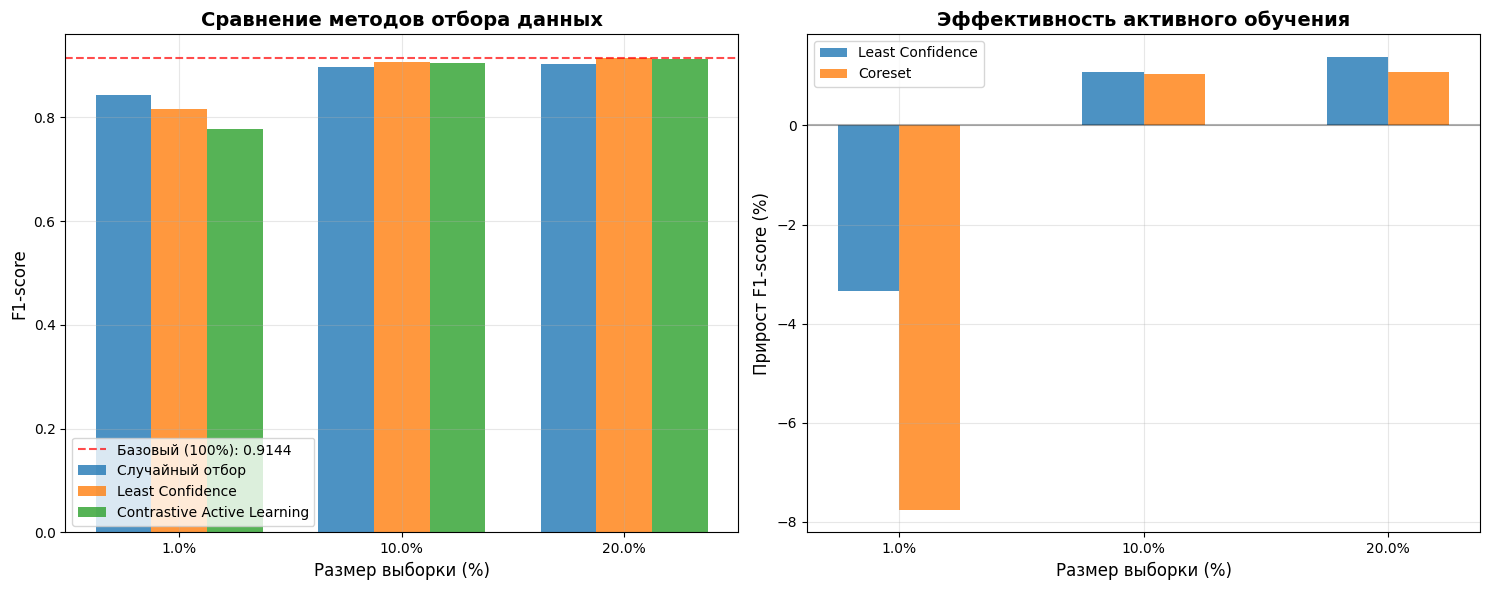

In [30]:
create_comparison_plots(results_random, results_all, 0.9144, sample_sizes)

In [37]:
def print_results_table(results_random, results_al, baseline_f1, sample_sizes):
    headers = ["Метод", "1% выборки", "10% выборки", "20% выборки", "Базовый (100%)"]
    data = []
    data.append(headers)
    data.append(["Полная выборка", "-", "-", "-", f"{baseline_f1:.4f}"])
    
    random_row = ["Случайный отбор"]
    for size in sample_sizes:
        mean = results_random[size]['mean']
        random_row.append(f"{mean:.4f}")
    random_row.append("-")
    data.append(random_row)

    lc_row = ["Least Confidence"]
    for size in sample_sizes:
        mean = results_al['Least Confidence'][size]['mean']
        improvement = (mean - results_random[size]['mean']) / results_random[size]['mean'] * 100
        lc_row.append(f"{mean:.4f} (+ {improvement:.1f}%)")
    lc_row.append("-")
    data.append(lc_row)
    
    cs_row = ["Contrastive Active Learning"]
    for size in sample_sizes:
        mean = results_al['Contrastive Active Learning'][size]['mean']
        improvement = (mean - results_random[size]['mean']) / results_random[size]['mean'] * 100
        cs_row.append(f"{mean:.4f} (+ {improvement:.1f}%)")
    cs_row.append("-")
    data.append(cs_row)
    
    for row in data:
        print(f"{row[0]:<40} {row[1]:<20} {row[2]:<20} {row[3]:<20} {row[4]:<20}")

lc_means = [results_all['Least Confidence'][s]['mean'] for s in sample_sizes]
cs_means = [results_all['Contrastive Active Learning'][s]['mean'] for s in sample_sizes]
print_results_table(results_random, results_all, 0.9144, sample_sizes)


Метод                                    1% выборки           10% выборки          20% выборки          Базовый (100%)      
Полная выборка                           -                    -                    -                    0.9144              
Случайный отбор                          0.8440               0.8967               0.9028               -                   
Least Confidence                         0.8159 (+ -3.3%)     0.9064 (+ 1.1%)      0.9154 (+ 1.4%)      -                   
Contrastive Active Learning              0.7786 (+ -7.8%)     0.9060 (+ 1.0%)      0.9126 (+ 1.1%)      -                   


## Анализ результатов

- Активное обучение позволило увеличить точность модели, используя тот же объем размеченных данных.

- Случайный отбор показал довольно неплохую эффективность. Связка TF-IDF + LogisticRegression хорошо справилась с классификацией даже на очень малых данных.

- Алгоритмы активного обучения показывают свое превосходство над случайным при умеренных объемах выборки (в данной работе 10-20%). Активное обучение не всегда дает преимущество на малых выборках, особенно в условиях, когда случайный отбор уже показывает высокие результаты.

- Least Confidence оказался простым, быстрым и довольно эффективным алгоритмом.

- Contrastive Active Learning показал результаты хуже, чем LC. При этом результаты всё равно довольно хорошие. Далее стоило бы занятся подбором параметра k_neighbors, который скорее всего сможет ещё увеличить f1-score. По времени работы этот алгоритм довольно долгий, так как использует KNN.